# Import packages

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support
import shap

# import stored variables from previous notebook
%store -r model_metrics_dict

# Load data

In [2]:
raw_data = pd.read_csv('../Data/Final/players_outfield_prepared.csv')
data = raw_data.copy()
df = pd.DataFrame(data)
pd.set_option('display.max_columns', None)
data.head()

,Age,Height,Weight,Overall,Potential,Growth,TotalStats,BaseStats,BestPosition,IntReputation,WeakFoot,SkillMoves,AttackingWorkRate,DefensiveWorkRate,PaceTotal,ShootingTotal,PassingTotal,DribblingTotal,DefendingTotal,PhysicalityTotal,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,STRating,LWRating,LFRating,CFRating,RFRating,RWRating,CAMRating,LMRating,CMRating,RMRating,LWBRating,CDMRating,RWBRating,LBRating,CBRating,RBRating,GKRating,Top_5_league
0,35,169,67,91,91,0,2190,452,0,5,4,4,1,1,81,89,90,94,34,64,84,90,70,91,88,95,93,93,90,93,87,76,91,92,95,86,68,70,68,91,44,40,93,94,75,96,20,35,24,6,11,15,14,8,90,90,91,91,91,90,91,91,88,91,67,66,67,62,53,62,22,1
1,34,185,81,91,91,0,2147,455,3,4,4,4,2,2,80,88,83,87,39,78,75,92,90,89,88,87,82,73,76,91,79,80,78,92,72,87,79,82,82,80,63,39,92,89,84,90,43,24,18,13,11,5,5,7,91,87,89,89,89,87,91,89,84,89,67,67,67,63,58,63,21,1
2,33,185,81,91,91,0,2205,458,13,5,4,4,0,2,75,91,79,86,44,83,71,94,91,84,89,85,79,85,70,89,76,75,77,93,82,91,85,76,87,84,81,49,94,81,90,88,35,42,19,15,6,12,8,10,91,85,88,88,88,85,88,86,83,86,67,69,67,64,63,64,22,1
3,31,181,70,91,91,0,2303,483,4,4,5,4,0,0,74,88,93,87,64,77,94,85,55,93,83,88,89,83,93,90,76,73,76,91,78,92,63,88,74,91,75,66,88,94,83,89,68,65,53,15,13,5,10,13,86,88,87,87,87,88,91,91,91,91,82,82,82,78,72,78,24,1
4,23,182,73,91,95,4,2177,470,13,4,4,5,0,1,97,89,80,92,36,76,78,93,72,85,83,93,80,69,71,91,97,97,93,93,81,88,77,87,76,82,64,38,92,83,80,88,26,34,32,13,5,7,11,6,92,90,90,90,90,90,92,92,84,92,70,66,70,66,57,66,21,1


## Check shape and target value balance

In [3]:
df.shape

(16478, 72)

In [4]:
df['Top_5_league'].value_counts()

0    13908
1     2570
Name: Top_5_league, dtype: int64

The 1s in our target variable (representing the players that play in the top 5 leagues) make up a small portion of the dataset. Let's see how the model performs, if it performs poorly then balancing the dataset is something to be considered.

# Remove features
- Only features that were determined to be useful (by way of having significant differences in mean and median values) will be included

In [5]:
df = df[['Overall', 'Potential', 'SkillMoves', 'PaceTotal', 'ShootingTotal',
       'PassingTotal', 'DribblingTotal', 'DefendingTotal', 'PhysicalityTotal',
       'Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys',
       'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Agility', 'Reactions',
       'ShotPower', 'LongShots','Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties',
       'Composure', 'Marking', 'StandingTackle', 'SlidingTackle', 'STRating',
       'LWRating', 'LFRating', 'CFRating', 'RFRating', 'RWRating', 'CAMRating',
       'LMRating', 'CMRating', 'RMRating', 'LWBRating', 'CDMRating',
       'RWBRating', 'LBRating', 'CBRating', 'RBRating','Top_5_league']]

df.head()

,Overall,Potential,SkillMoves,PaceTotal,ShootingTotal,PassingTotal,DribblingTotal,DefendingTotal,PhysicalityTotal,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Agility,Reactions,ShotPower,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,STRating,LWRating,LFRating,CFRating,RFRating,RWRating,CAMRating,LMRating,CMRating,RMRating,LWBRating,CDMRating,RWBRating,LBRating,CBRating,RBRating,Top_5_league
0,91,91,4,81,89,90,94,34,64,84,90,70,91,88,95,93,93,90,93,91,92,86,91,44,40,93,94,75,96,20,35,24,90,90,91,91,91,90,91,91,88,91,67,66,67,62,53,62,1
1,91,91,4,80,88,83,87,39,78,75,92,90,89,88,87,82,73,76,91,78,92,87,80,63,39,92,89,84,90,43,24,18,91,87,89,89,89,87,91,89,84,89,67,67,67,63,58,63,1
2,91,91,4,75,91,79,86,44,83,71,94,91,84,89,85,79,85,70,89,77,93,91,84,81,49,94,81,90,88,35,42,19,91,85,88,88,88,85,88,86,83,86,67,69,67,64,63,64,1
3,91,91,4,74,88,93,87,64,77,94,85,55,93,83,88,89,83,93,90,76,91,92,91,75,66,88,94,83,89,68,65,53,86,88,87,87,87,88,91,91,91,91,82,82,82,78,72,78,1
4,91,95,5,97,89,80,92,36,76,78,93,72,85,83,93,80,69,71,91,93,93,88,82,64,38,92,83,80,88,26,34,32,92,90,90,90,90,90,92,92,84,92,70,66,70,66,57,66,1


# Split data

In [6]:
X = df.drop(['Top_5_league'], axis=1)
y = df['Top_5_league']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y, random_state=42)

# Hyperparameter tuning

In [7]:
# set value counts for the scale pos weight hyperparameter
value_counts = y_train.value_counts()

# set parameters
param_grid = {'n_estimators': [10, 50, 100, 500, 1000, 1500], # number of trees to use in the ensemble
              'learning_rate': [0.1, 0.2, 0.3, 0.4], # Controls the step size at each iteration while moving towards the global minimum loss function
              'max_depth': [3, 5, 10, 20], # set max depth of decision tree
              'subsample': [0.4, 0.6, 0.8, 1.0], # The fraction of training instances to use for each tree. Decreasing this can improve generalization but 
              # can also decrease training speed.
              'colsample_bytree': [0.25, 0.5, 0.6, 0.8, 1.0], 
              'scale_pos_weight': [float(value_counts[0]/value_counts[1])], # Used for imbalanced classification tasks. Value should be set to the ratio of 
              # negative class to positive class
              'min_child_weight': [0.5, 1, 3, 5, 7, 9] # The minimum sum of instance weight needed in a child. Increasing this value can reduce overfitting
             }

# instantiate xgb classifier model
xgb_model = xgb.XGBClassifier()

# create random search variable and set the parameters
random_search = RandomizedSearchCV(estimator=xgb_model,
                                   param_distributions=param_grid,
                                   cv=5, # 5 is the default value for number of folds
                                   n_iter=1000, # determines the number of parameter settings that are sampled (controls the total number of 
                                   # combinations of hyperparameters to try during the search)
                                   scoring='recall',
                                   n_jobs=-1,
                                   random_state=42,
                                   verbose=3)

In [8]:
%%time
# Fit the model to the training data
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
CPU times: user 18.2 s, sys: 2.62 s, total: 20.8 s
Wall time: 8h 56min 47s


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None, max_bin=None,...
                                           reg_alpha=None, reg_lambda=None, ...),
                   n_iter=1000, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.25, 0.5, 0.6,
                                                             0.8, 1.0],
                                        'learning_rate': [0.1, 0.2, 0.3, 0.4],
                                        'max_depth': [3, 5, 10, 20],
                                        'min_child_weight': [0.5, 1, 3, 5, 7,
                                                             9],
                                        'n_estimators': [10, 50, 100, 500, 1000,
                                                         1500],
                                        'scale_pos_weight': [5.41147859922179],
                                        'subsample': [0.4, 0.6, 0.8, 1.0]},
                   random_state=42, scoring='recall', verbose=3)

In [16]:
# print the best hyperparameters
print("Best Hyperparameters:\n", random_search.best_params_)
print("Best estimator:\n", random_search.best_estimator_)

Best Hyperparameters:
 {'subsample': 0.8, 'scale_pos_weight': 5.41147859922179, 'n_estimators': 100, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
Best estimator:
 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1.0,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=5,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)


In [17]:
# store best model in a variable
xgb_model = random_search.best_estimator_

# Evaluate Model

In [18]:
# Use the best model to make predictions on the test set
xgb_predictions = xgb_model.predict(X_test)

In [19]:
# Calculate and print the accuracy of the model
accuracy = accuracy_score(y_true=y_test, y_pred=xgb_predictions)
print("Accuracy:", accuracy)

Accuracy: 0.8228155339805825


## Confusion Matrix

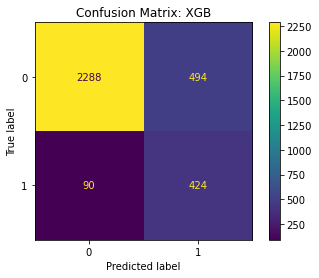

In [20]:
cm = confusion_matrix(y_true=y_test, y_pred=xgb_predictions, labels=xgb_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_model.classes_)
disp.plot()
plt.title("Confusion Matrix: XGB")
plt.show()

In [21]:
print(classification_report(y_true=y_test, y_pred=xgb_predictions))

              precision    recall  f1-score   support

           0       0.96      0.82      0.89      2782
           1       0.46      0.82      0.59       514

    accuracy                           0.82      3296
   macro avg       0.71      0.82      0.74      3296
weighted avg       0.88      0.82      0.84      3296



## Shapley values

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


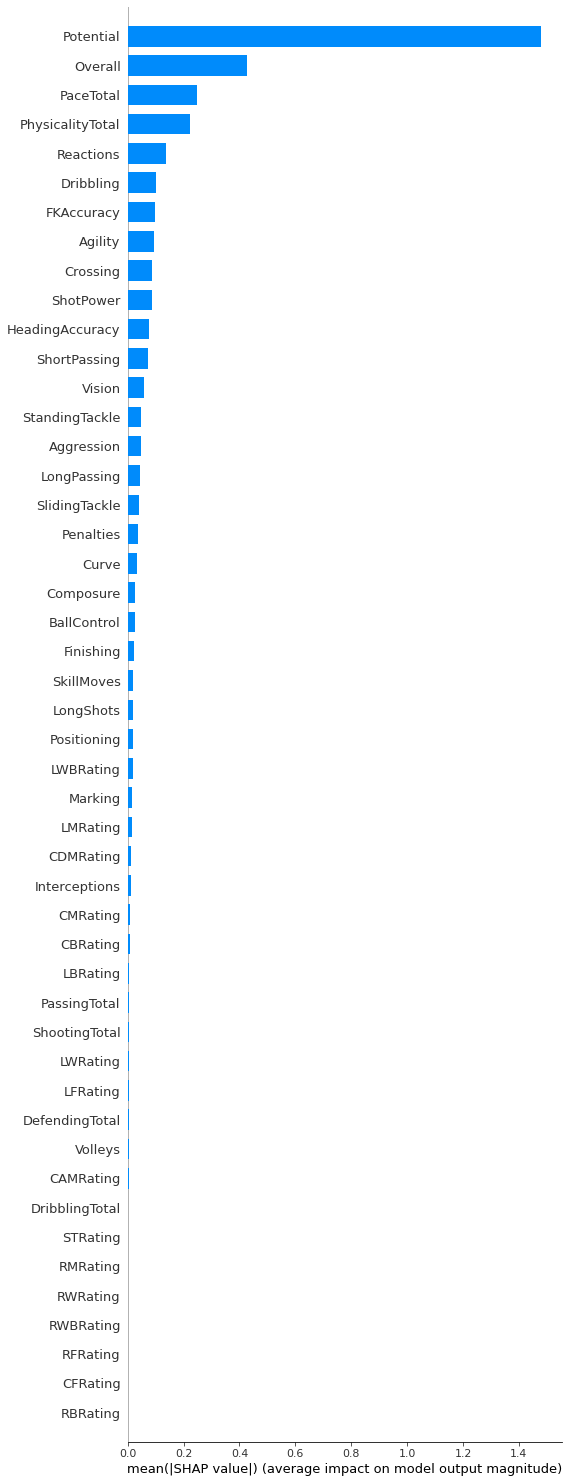

In [22]:
shap_values = shap.TreeExplainer(xgb_model).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar", max_display=100)

# Compare models

In [40]:
# create a dataframe to allow quick comparison of models (add more models to the dictionary as they are created)
metrics = precision_recall_fscore_support(y_true=y_test, y_pred=xgb_predictions)

# Extract precision, recall, f1-score, and support and round to two decimal places
precision = [round(p, 2) for p in metrics[0]]
recall = [round(r, 2) for r in metrics[1]]
f1_score = [round(f, 2) for f in metrics[2]]
support = metrics[3]

# update dictionary to include new model
model_metrics_dict['XGB_Tuned_Random_Search'] = {
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1_score,
        "Accuracy": round(accuracy, 2),
        "Support": support,
}

In [41]:
# create dataframe from model metrics dictionary - values will be displayed as a list of negative and positive class data
df_report = pd.DataFrame(data=model_metrics_dict)
# rename the index column to 'metric'
df_report.index.rename('Metric', inplace=True)
# reset the index so there is a standard numerical index
df_report.reset_index(inplace=True)
# check output
df_report

,Metric,XGB_Baseline,XGB_Tuned_Random_Search
0,Precision,"[0.92, 0.73]","[0.96, 0.46]"
1,Recall,"[0.96, 0.56]","[0.82, 0.82]"
2,F1 Score,"[0.94, 0.64]","[0.89, 0.59]"
3,Accuracy,0.9,0.82
4,Support,"[2782, 514]","[2782, 514]"


## Store variables

In [42]:
%store model_metrics_dict

Stored 'model_metrics_dict' (dict)


# Next steps
- The tuned model is less precise but has better recall for positive classes than the baseline XGB model.
- The tuned model is less accurate overall than the baseline XGB model (82% tuned vs. 90% baseline).
- Possible ways to improve the accuracy of the model:
    - Balance dataset with SMOTE
    - Remove features that are not influential, as indicated by Shap values